# Web Crawler

Collect text data from the PTT forum, process the article texts, and finally create a word cloud for a quick overview of the topics in these collected texts.

## Crawling Data from PTT

In [1]:
import requests
from bs4 import BeautifulSoup as soup  # HTML data structure
from lxml import etree


# extract article hyperlinks from an index page
def extractArtLinks(url):
    r = requests.get(url, cookies={'over18': '1'})
    page_soup = soup(r.text, "html.parser")
    containers = page_soup.findAll("div", {"class": "r-ent"})
    art_links = []
    for container in containers:
        # Finds all link tags "a" from within the first div.
        art_link = container.find('a')
        if art_link:
            #print(art_link['href'])
            #print(container.find('div',{'class':'title'}).get_text())
            art_meta = container.find('div', {'class': 'meta'})
            #print(art_meta.find('div',{'class':'author'}).get_text())
            #print(art_meta.find('div',{'class':'date'}).get_text())

            art_links.append({
                'push':
                container.find('div', {
                    'class': 'nrec'
                }).get_text(),
                'title':
                container.find('div', {
                    'class': 'title'
                }).get_text().strip(),
                'date':
                art_meta.find('div', {
                    'class': 'date'
                }).get_text(),
                'author':
                art_meta.find('div', {
                    'class': 'author'
                }).get_text(),
                'link':
                art_link['href'],
                'text':
                extractArtText('https://www.ptt.cc' + art_link['href'])
            })

    return (art_links)


# find the previous index page link
def findPrevIndex(url):
    r = requests.get(url, cookies={'over18': '1'})
    page_soup = soup(r.text, "html.parser")
    btn = page_soup.select('div.btn-group > a')
    up_page_href = btn[3]['href']
    next_page_url = 'https://www.ptt.cc' + up_page_href
    return (next_page_url)


# extract article contents from  the article hyperlink
def extractArtText(url):
    r = requests.get(url, cookies={'over18': '1'})
    #page_soup = soup(r.text, "lxml")
    #print(page_soup.find("div",{"id":"main-content"}).get_text())
    #art_text=page_soup.select('div#main-content', limit=1)[0].text
    content = r.content.decode()
    html = etree.HTML(content)
    art_text = html.xpath(
        "//div[@id='main-content']/text()[not(self::div|self::span[@class='f2'])]"
    )
    return ''.join(list(art_text))

In [2]:
## Debug Use

# url = 'https://www.ptt.cc/bbs/Food/M.1602332821.A.6F3.html'
# r = requests.get(url, cookies={'over18': '1'})
# #page_soup = soup(r.text, "lxml")
# #print(page_soup.find("div",{"id":"main-content"}).get_text())
# #art_text=page_soup.select('div#main-content', limit=1)[0].text
# content = r.content.decode()
# html = etree.HTML(content)
# art_text = html.xpath(
#     "//div[@id='main-content']/text()[not(self::div|self::span[@class='f2'])]")

# print(''.join(list(art_text)))

```{note}
For CSS selector, don't know how to set conditional criteria to select only texts under div#main-container but not those included in the child div.article-metaline and span.f2.

So here I use the XPath, which requires the lxml package.
```

In [3]:
# main()
num_of_index_page = 5
board_name = 'Food'
url = 'https://www.ptt.cc/bbs/{}/index.html'.format(board_name)
all_links = []
for page in range(1, num_of_index_page):
    all_links = all_links + extractArtLinks(url)
    url = findPrevIndex(url)
len(all_links)

70

In [4]:
type(all_links[2])
print(all_links[2])

{'push': '', 'title': '[食記] 台中/九合脆皮烤鴨：炒鴨骨+高麗菜必點', 'date': '10/27', 'author': 'maggie024', 'link': '/bbs/Food/M.1603798656.A.EC2.html', 'text': '\n======================================================\n◎介紹店鋪：[九合脆皮烤鴨 西屯路│西屯區]\n◎地址：台中市北區西屯路一段413號\n◎電話：0906-161181\n◎營業時間：10:30Am-07:30Pm\n◎消費時間→109年10月\n======================================================\n●圖文網誌版→\n\n講到台中烤鴨，你就不能不提到在西屯路的【九合脆皮烤鴨】，\n先前總會注意到九合就是因為每次都會看到店門口掛的廣告布條，\n上面寫著「捐血送烤鴨」活動，先前幾乎每年都會看到，\n我聽過捐血送電影票、送赤鬼牛排券，送烤鴨卻只有僅此一家，\nGOOGLE評價612則有4.1高分，而且每次介紹烤鴨網友留言都必推這家。\n\n【九合脆皮烤鴨】目前在台中有兩家店，西屯路店面不大卻是最早開始的，\n每次經過路口停紅綠燈總會聞到香味誘惑，意圖使人下班就想帶烤鴨回家。\n雖然說沒有美村路烤鴨那樣的大排長龍，可是不少網友總在留言間推薦，\n而且實際上過來買才會發現生意相當好，平日竟然還比假日更好，\n看到櫃檯上滿滿黑色袋子包裝我才知道原來也可以先電話預訂。\n小小的前檯片鴨、剁骨俐落快速，另外一個人負責大火爆炒鴨架，\n在旁邊邊看著片鴨油亮擺盤，從鴨身還有油汁滴出好想直接先偷捏幾片來吃。\n我記得第一次買九合整隻全鴨是450元，現在幾乎台中每家都是500元上下了，\n一樣可以買半隻價格是280元，只是九合有一味跟台中其他烤鴨都不同的是..\nMENU上有一項「炒骨加高麗菜/40元」，這個是幾乎每個網友都大推的，\n高麗菜、炒高麗菜不難吃到，但能在烤鴨店的炒鴨架中吃到高麗菜蠻少見的。\n而且加了高麗菜，但原本該有的九層塔、蒜、蔥還是一樣不少。\n\n【招牌脆皮烤鴨│全隻500元/半隻280元+40元炒高麗菜】\n擺盤上基本跟其他家烤鴨差不多，整大盤的片鴨，一大包的炒

In [5]:
print('Push: {push:s} \n'
      'title: {title:s} \n'
      'date: {date:s} \n'
      'author: {author:s} \n'
      'link: {link:s} \n'
      'text: {text:.20} \n'.format(**all_links[3]))

Push: 1 
title: [食記] 高雄美濃 軒味屋彩色粄條 x 濃夫生活。 
date: 10/27 
author: longloveyu 
link: /bbs/Food/M.1603800141.A.BC2.html 
text: 

作者: longloveyu (yu 



## Text Normalization

In [6]:
import sys
sys.path.insert(1, '../nlp')
import text_normalizer_zh as tn

In [7]:
print(all_links[3]['text'])



作者: longloveyu (yu) 看板: Kaohsiung
標題: [食記] 美濃 軒味屋彩色板(粄)條x濃夫生活。
時間: Tue Oct 27 20:02:00 2020

   
   地    址：高雄市美濃區中山路二段384號
   電    話：07-681 2820
   營業時間：10:00-14:00
   消費日期：2020.9
  ------------------------------------------------------------------
   個人圖文blog心得： 




因為朋友有抽到農遊券，所以請了我們全家一起去美濃玩耍及大啖美濃客家美食。
其實原來的目的地是想去玩漂漂河的，
沒想到今日撲空，據說是上游因素所以下游沒什麼水量。

而我們來到美濃的第一站，即是近期ig網美店，
因為她們家的粄條是彩色的，這特殊色彩的粄條可是目前美濃地區的先驅者呢！
所以吸引了不少媒體、部落客爭相前往採訪、拍攝品嚐。
我們也是來跟風的啦！


窗外貼有告示。
我們今日前往時間尚早，所以很幸運的一抵達店門口即被安排入座。



牆面上貼著老板夫妻返鄉的小故事。

緊接著先上菜單:


其中千層麻糬粄很吸引人，沒想到要提早預約的熱門品項，
臨時起意想吃可是吃不到的呢。
不過日前在google評價上看到網友分享，店家目前已停賣千層麻糬粄了。


色彩鮮豔繽紛，為了民眾安心享用，特別說明使用了什麼食材
有火龍果、地瓜葉、山黃？(看不懂XD)、蝶豆花、甜菜根、蕃茄、橙蜜香



今日消費內容。
其實後面我們還陸續加點幾樣，但此文就以上面內容來逐一分享圖片及簡單心得囉。



份量不多，
而她們的麵條嚴格說沒什麼特殊、明顯的「味道」，
但是口感嚐起來真的有比一般粄條還要Q彈可口哦！

菜單上第二項排骨湯被店家漏單了XD，
一直到要離席都未見上菜。


還滿好吃的，肥肉部份也不會讓人覺得油膩
不過真的太鹹了。


大腸還滿鮮嫩的，不過吃完只有酸而已。




價格有點貴，上面放著碎肉末，味道滿特別的。
小孩吃完讚不絕口，又另外加點了。


份量略少，麵條下方是豆芽菜等配菜居多。

當我們菜都上得差不多時，遲遲未見熱門打卡餐點啊，
這才驚覺原來我們根本沒點XD

「彩衣涼粄」的寬度跟厚度，與「彩色粄條」看起來都不太一樣，
實際品嚐起來的

In [8]:
raw = [art['text'] for art in all_links if len(art) != 0 and len is not None]
raw_normalized = tn.normalize_corpus(raw)

Building prefix dict from /Users/Alvin/GoogleDrive/_MySyncDrive/RepositoryData/data/jiaba/dict.txt.jiebatw.txt ...


Loading model from cache /var/folders/n7/ltpzwx813c599nfxfb94s_640000gn/T/jieba.u1b52b47246a0f2e6497af6bbe107adac.cache


Loading model cost 0.558 seconds.


Prefix dict has been built successfully.


In [9]:
import pandas as pd

corpus_df = pd.DataFrame({"raw": raw, "normalized": raw_normalized})

In [10]:
corpus_df.head(2)

,raw,normalized
0,\n電話：02 2727 1098\n地址：台北市信義區忠孝東路五段524巷一弄7號\n營業...,電話 地址 台北市 信義區 忠孝東路 五段 巷 一弄 號 營業 時間 週一 二 公休 消費 ...
1,\n 餐廳名稱：Teaday喝茶天 茶家食堂\n 消費時間：2020年/10月\n ...,餐廳 名稱 喝茶 天 茶家 食堂 消費 時間 年 月 地址 新 北市 鶯歌區 重慶街 號 鶯...


In [11]:
raw[5]

'\n   餐廳名稱：七里香 水煎包 滷味\n   消費時間：2020年/10月\n          (例：2010年7月，未提供則文章不予保留，多訪綜合心得也請標上起迄時間)\n   地址：台東縣台東市正氣路385巷7號\n   電話：089-334615\n   營業時間：15:30-00:00（週一公休）\n   每人平均價位：25-100\n   可否刷卡：否\n   有無包廂：無\n   推薦菜色：水煎包\n\n  圖文網誌版：\n\n文字版：\n\n這次騎車從高雄一路繞鵝鑾鼻來到台東，時間已經接近六點，快天黑了。\n\n想想晚餐不想要逛夜市，也不想再吃常聽到的藍蜻蜓、阿鋐炸雞、榕樹下米苔目等名店。\n\n於是找到了這間位於鐵花村旁的<七里香 水煎包 滷味>。\n\n\n其實地點頗不起眼，從正氣路要彎進去位於巷子裡的店面，很容易就錯過巷子口，我自己就\n繞了兩次.....\n\n用餐區算是半戶外，不過旁邊也不是道路，比較沒有車輛行經廢氣的問題，上面則是有遮雨\n棚。\n\n七里香只賣滷味和水煎包兩種。\n\n水煎包一顆25元大洋，滷味則是各有價格，種類也很多，可以自己挑選。\n\n青菜部分記得有分30元跟50元兩種，也都會先包好分量給客人參考。\n\n若是滷味以兩計算想吃多少錢但不知道怎麼夾的話，也可以問店員，店員會幫你挑選或是提\n供建議。\n\n蔬菜區近照。\n\n滷味區近照。其實種類還不少。\n\n我點了一顆水煎包、高麗菜30元、豬耳朵和海帶，總共95元。\n\n\n點玩過沒多久，水煎包就先上菜，\n\n當下只覺得「真的有夠大顆」。\n\n可能照片看不太出來，不過大概是比成年男性一顆拳頭還要大的程度。\n\n拿我的手當比例尺對照一下，應該可以比較清楚。\n\n原本要直接吃原味，但在店員大力推薦之下，淋上了特別的醬汁。\n\n很奮力地咬了一口之後，看到裡面的餡料。\n\n我覺得皮的厚度中規中矩，但餡料塞得很紮實，絕對是有那種要你吃一顆就飽的那種架式。\n(確實我吃了一顆就6~7分飽了)\n\n接著來吃一下滷味，印象中滷味的醬汁好像跟水煎包的醬汁一模一樣，是帶點蒜味的醬汁，\n但是不會辣。\n\n海帶滷的偏軟，個人喜歡這樣的口感，不過每個人喜好不同就自行參考囉。\n\n豬耳朵則是恰到好處，軟硬度適中，軟骨部分也很脆但不會太硬，不錯吃。\n\n在吃的時候

In [12]:
raw_normalized[4]

'圖文 網誌 建議 閱讀 版 新 北斗 石頭 火鍋 地址 台東縣 台東市 四維路 三段 號 電話 建議 訂位 營業 時間 路邊 停車 可 刷卡 又 到 了 三餐 都 想 吃 火鍋 的 季節 掏出 灰鴿 黨證 而 月 中 至 月 中 是 池上 稻浪 最美 的 金黃 時刻 想起 了 市區 這間 好吃 又 不貴 的 老牌 自助 石頭 火鍋 火鍋 黨員 如 我們 立刻 掏出 記憶體 照片 來 更 新黨 誌 如果 你們 到 台東 玩耍 正好 可以 晚餐 開鍋 哦 用餐 日期 雖然 行前 查詢 上 已 有 不少 好評 但辦 入住 的 時候 還是 諮詢 了 下 我們 的 民宿 主人 聽到 他們 說 有 組 熟客 每到 台東 都 要 吃 新 北斗 石頭 火鍋 瞬間 提高 了 兩個 火鍋 黨員 心內 的 期待值 阿 哈哈 花東 旅行 大海 山嵐 熱氣球 金針花 台東 花蓮 天 夜 行程 總表 台東 住宿 鹿野 克卜勒 民宿 閃閃 星空 下 的 歲月 靜好 位於 台東 市區 四維路 上 的 新 北斗 石頭 火鍋 路邊 有 不少 停車格 所以 開車 過來 也 很 方便 因為 聽說 是 很 受 歡迎 的 在 地 老店 我們 便 提早 預訂 了 晚餐 第一輪 的 位置 牆上 告示 有多種 鍋底 類型 可供 選擇 從 石頭 火鍋 韓式 泡菜 鍋 四川 麻辣鍋 高鈣 沙嗲 鍋 雙選 鴛鴦 鍋到 養生 素食 鍋 無 爆香 不歡 的 我們 選 好了 原味 石頭 火鍋 就 可以 走到 冰箱 挑菜 囉 一排 過去 幾個 大 冰箱 裡 滿滿 都 是 菜 與 料 連不 常見 的 蘑菇 也 都 有 且 價格 不貴 不等 使用 了 封膜 兼具 衛生 喜歡 這樣 自己 來 的 自助 火鍋城 沾醬 台 簡簡單單 特色 是 自家 製 帶 著 花生 香氣 的 手工 沙茶 如果 有 香菜 就 更 棒 了 欸 選好 肉片 與 想要 一起 下鍋 的 香料 菜 以後 服務 人員 會 幫忙 以 洋蔥 麻油 爆香 炒肉 至 半熟 以後 取出 才 接著 倒入 高湯 熬煮 最後 就 會 得到 這鍋 油油 亮亮 的 邪惡 卡路里 高湯 了 哈哈 哈 拍完 照 以後 我們 便 把 所有 蔬菜 與 丸子 通通 下鍋 很具 份量 的 肥美 蛤蜊 也 很 值得 點 這時 該 如何 分辨 老鼠屎 的 臭 蛤 呢 當整 鍋湯 突然 散發出 臭水溝 

- [Unicode List](https://en.wikipedia.org/wiki/List_of_Unicode_characters)
- [Unicode Categories](https://unicodebook.readthedocs.io/unicode.html)

In [13]:
text = raw[0]
text

'\n電話：02 2727 1098\n地址：台北市信義區忠孝東路五段524巷一弄7號\n營業時間：12:00-14:30,17:30-21:30(週一二公休)\n消費時間：2020年10月\n每人平均價位：400~600 低消350\n服務費：無\n外送：無\n其他支付：無\n---------------------\n\n圖文網誌好讀版本:\n\n---------------------\n後山埤站往永春的方向漫步探索巷弄美食，途經忠孝東路五段524巷一弄這條充滿回憶的\n巷子，回憶起國小下課時，總是找三五好友從成德國小那出發，騎著腳踏車前往麥當勞吃\n下午茶，那時吉事漢堡才15還是19元的樣子，每次都怒吃三顆，超爽DER。\n\n\n隨著年齡長大，也很少走這條巷子了，一眼望去怎有家感覺很神秘有院子的小餐館，門口\n也很神秘沒放菜單，我們倆一直猜想既然叫福旺很中式的名字，那應該是賣個麻辣鍋或中\n式簡餐之類了吧！好奇心驅使我們，上網看了一下原來是義式餐館，真是特色，直覺告訴\n我這家店應該很棒，所以就帶著期待的心踏進來了。\n\n\n\n\n\n\n\n我們都很喜歡這個小庭院的感覺，很自在、舒服、有家的感覺，巧妙運用植栽、綠意等元\n素，使整體空間活絡充滿生氣。\n\n\n最喜歡這個位置，在這邊拿本書，輕鬆愜意的渡過下午時光，真棒！喜歡這樣的生活。\n\n\n隨著步行者一同進入這咖啡餐館吧！\n\n\n\n\n\n豬仔與旁邊的熊仔一起拍照\n\n\n進入店內後，平時需要預約，今天的我們蠻幸運沒預約也有位，可能是下雨的關係吧，店\n內大約２０人左右的空間大小，其實沒有很大，想來吃飯的話記得要先訂位比較保險。\n\n\n\n除了一般座位外，也有這種吧台位，其實我蠻喜歡這種吧台位，偶爾可以與廚師互動，蠻\n有趣的，這一區的位置也適合單人前往用餐。\n\n\n\n店內的氣氛也很棒，以木質調為基礎，搭配點帶有日式風情的杯具，光線也偏溫暖柔和，\n讓人在裡面很自在放鬆。\n\n\n\n油品及真空穀米也成為了具藝術氣息的裝飾品。\n\n\n\n店內的是走義式風格的餐酒館形式，當然除了想得到的義大利、燉飯外，也有些排餐，價\n位大約是350~450間，偏中價位不算便宜。他們的海鮮聽說很棒，烤雞也很多人點，其他\n的產品看了一下其實都很特別耶，特別是菊花肉！你說～你是不是在想

In [14]:
import unicodedata

result = ''.join(ch for ch in text
                 if unicodedata.category(ch)[0] not in ['P', 'S'])
result

'\n電話02 2727 1098\n地址台北市信義區忠孝東路五段524巷一弄7號\n營業時間1200143017302130週一二公休\n消費時間2020年10月\n每人平均價位400600 低消350\n服務費無\n外送無\n其他支付無\n\n\n圖文網誌好讀版本\n\n\n後山埤站往永春的方向漫步探索巷弄美食途經忠孝東路五段524巷一弄這條充滿回憶的\n巷子回憶起國小下課時總是找三五好友從成德國小那出發騎著腳踏車前往麥當勞吃\n下午茶那時吉事漢堡才15還是19元的樣子每次都怒吃三顆超爽DER\n\n\n隨著年齡長大也很少走這條巷子了一眼望去怎有家感覺很神秘有院子的小餐館門口\n也很神秘沒放菜單我們倆一直猜想既然叫福旺很中式的名字那應該是賣個麻辣鍋或中\n式簡餐之類了吧好奇心驅使我們上網看了一下原來是義式餐館真是特色直覺告訴\n我這家店應該很棒所以就帶著期待的心踏進來了\n\n\n\n\n\n\n\n我們都很喜歡這個小庭院的感覺很自在舒服有家的感覺巧妙運用植栽綠意等元\n素使整體空間活絡充滿生氣\n\n\n最喜歡這個位置在這邊拿本書輕鬆愜意的渡過下午時光真棒喜歡這樣的生活\n\n\n隨著步行者一同進入這咖啡餐館吧\n\n\n\n\n\n豬仔與旁邊的熊仔一起拍照\n\n\n進入店內後平時需要預約今天的我們蠻幸運沒預約也有位可能是下雨的關係吧店\n內大約２０人左右的空間大小其實沒有很大想來吃飯的話記得要先訂位比較保險\n\n\n\n除了一般座位外也有這種吧台位其實我蠻喜歡這種吧台位偶爾可以與廚師互動蠻\n有趣的這一區的位置也適合單人前往用餐\n\n\n\n店內的氣氛也很棒以木質調為基礎搭配點帶有日式風情的杯具光線也偏溫暖柔和\n讓人在裡面很自在放鬆\n\n\n\n油品及真空穀米也成為了具藝術氣息的裝飾品\n\n\n\n店內的是走義式風格的餐酒館形式當然除了想得到的義大利燉飯外也有些排餐價\n位大約是350450間偏中價位不算便宜他們的海鮮聽說很棒烤雞也很多人點其他\n的產品看了一下其實都很特別耶特別是菊花肉你說你是不是在想一些怪怪的事想\n說菊花的肉也能吃嗎熊仔的第一個反應就是這樣那到底是什麼呢讓我們繼續看下去\n\n\n因此本次消費就簡單點了黑啤酒燉菊花肉細扁麵及油封鴨腿甜椒榛果燉飯這兩\n道平時也比較少吃到的口味啾竟如何待會揭曉\n\n\n酒後不開車安全有保障\

## Word Cloud

In [15]:
from collections import Counter
import imageio
from nltk.tokenize import WhitespaceTokenizer
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import pyplot as plt

In [16]:
## Check font paths
## !fc-list :lang=zh

ws = WhitespaceTokenizer()

tokens = [ws.tokenize(text) for text in raw_normalized]

In [17]:
from collections import Counter

# corpus token freq
tokens_freq = Counter(sum(tokens, []))
sorted(tokens_freq.items(), key=lambda x: x[1], reverse=True)

# corpus token freq per document
tokens_freq_per_doc = [Counter(wt) for wt in tokens]

# corpus token docfreq
tokens_df = Counter()

# map(tokens_df.update, (tfpd.keys() for tfpd in tokens_freq_per_doc))

for tfpd in tokens_freq_per_doc:
    tokens_df.update(tfpd.keys())

print(tokens_df)

Counter({'的': 70, '時間': 69, '是': 67, '有': 65, '號': 63, '電話': 62, '地址': 62, '營業': 62, '也': 62, '在': 62, '很': 61, '就': 59, '消費': 58, '了': 58, '吃': 57, '都': 57, '可以': 55, '不': 55, '月': 51, '餐廳': 51, '人': 50, '年': 49, '來': 49, '我': 48, '會': 48, '名稱': 48, '但': 47, '圖文': 46, '上': 46, '說': 44, '到': 43, '價位': 41, '菜單': 41, '沒有': 41, '要': 41, '覺得': 41, '多': 40, '因為': 40, '好': 40, '每人': 39, '後': 39, '就是': 39, '又': 39, '和': 38, '跟': 38, '好吃': 38, '味道': 38, '比較': 37, '口感': 36, '版': 36, '無': 35, '網誌': 35, '讓': 35, '元': 34, '非常': 34, '不錯': 34, '平均': 33, '所以': 33, '喜歡': 33, '再': 33, '推薦': 32, '店家': 32, '用餐': 31, '還': 31, '小': 30, '大': 30, '一': 30, '不過': 30, '他': 29, '口味': 29, '如果': 29, '去': 29, '其': 28, '時': 28, '才': 28, '感覺': 28, '看': 28, '等': 28, '整體': 28, '以': 28, '特別': 28, '選擇': 28, '餐點': 28, '不會': 28, '可': 28, '雖然': 28, '我們': 27, '最': 27, '與': 27, '話': 27, '看到': 27, '吃起來': 27, '個': 27, '有點': 27, '真的': 27, '還是': 26, '店': 26, '更': 26, '刷卡': 26, '台北市': 25, '應該': 25, '除了': 25, '搭配': 25, '可否': 25, '想

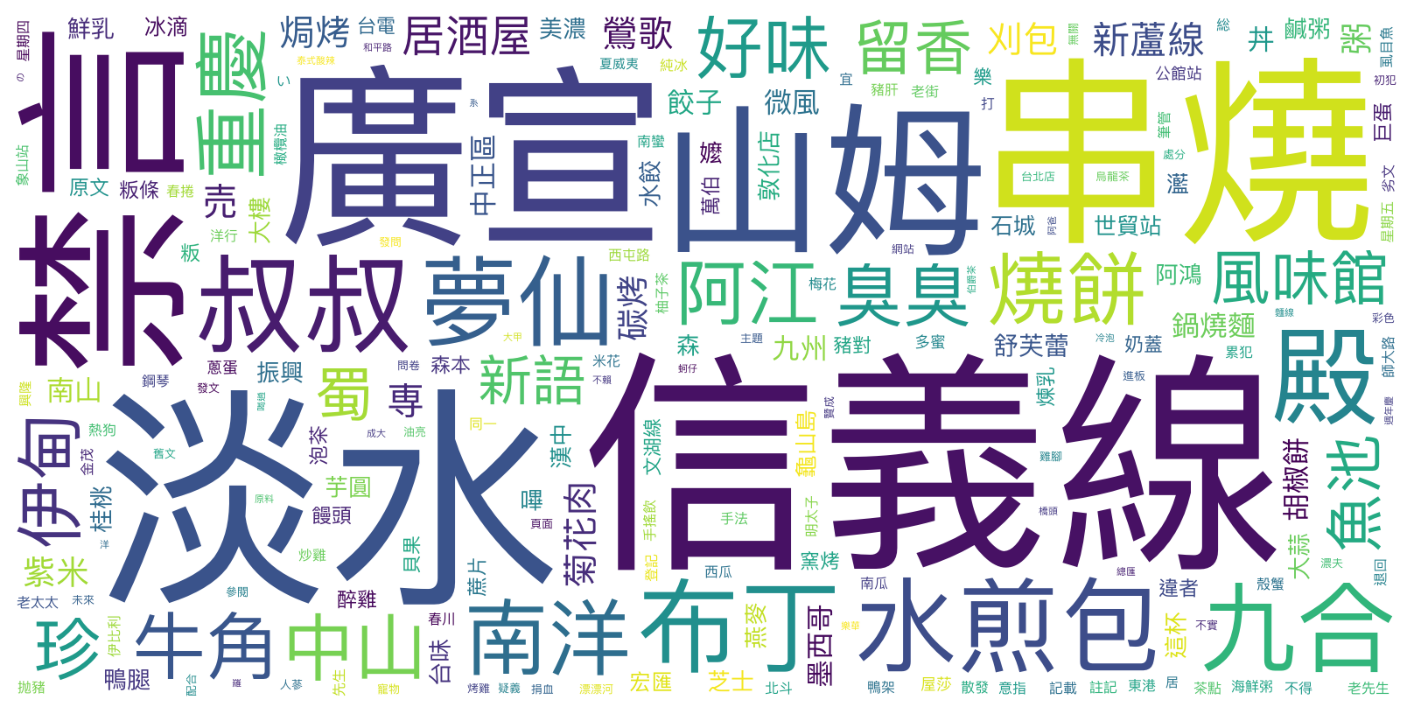

In [18]:
## Load stopwords
with open(
        '../../../RepositoryData/data/stopwords/tomlinNTUB-chinese-stopwords.txt'
) as f:
    stopwords = [w.strip() for w in f.readlines()]

# Create stopwords ad hoc
stopwords = set([
    '文章', '食記', '水桶', '刪除', '投票', '刪文', '連結', '板面', '板主', '規定', '違規', '使用',
    '所以', '禁止', '天', '票'
])

# Cutoff based on docfreq and stopwords
words2plot = dict([(w, tokens_freq[w]) for w, df in tokens_df.items()
                   if df < 2 and w not in stopwords and tokens_freq[w] >= 2])

wordcloud = WordCloud(font_path="/System/Library/Fonts/PingFang.ttc",
                      background_color='white',
                      stopwords=stopwords,
                      width=1600,
                      height=800,
                      margin=20)
# wordcloud.generate(' '.join([w for w in tokens_unnest if w not in stopwords]))
wordcloud.generate_from_frequencies(words2plot)
plt.figure(figsize=(20, 10), facecolor='w')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=1)
plt.show()
#plt.savefig('../data/twp-wordcloud2.png', facecolor='k', bbox_inches='tight')

:::{admonition} Exercise
How to seperate post texts from push texts?
:::
